In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MRK_

In [3]:
# First, we get the data
dataset = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/JPM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.83,40.36,39.30,40.19,12839400,JPM
2006-01-04,39.78,40.14,39.42,39.62,13491800,JPM
2006-01-05,39.61,39.81,39.50,39.74,8109400,JPM
2006-01-06,39.92,40.24,39.55,40.02,7966900,JPM
2006-01-09,39.88,40.72,39.88,40.67,16575200,JPM


In [4]:
train_df = dataset.loc['2006-01-01':'2016-12-31']
test_df = dataset.loc['2017-01-01':'2018-01-01']

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

train_list = scaler.fit_transform(train_df['Close'].values.reshape(-1,1))
test_list = scaler.transform(test_df['Close'].values.reshape(-1,1))

In [6]:
len(train_list), len(test_list)

(2769, 251)

In [7]:
import numpy as np
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(60, len(train_list)):
    X_train.append(train_list[i-60:i, 0])
    y_train.append(train_list[i, 0])
    
    
for i in range(60, len(test_list)):
    X_test.append(test_list[i-60:i, 0])
    y_test.append(test_list[i, 0])
    
    
X_train = np.array(X_train).reshape(len(X_train), len(X_train[1]), 1)
y_train = np.array(y_train).reshape(len(y_train), 1)

X_test = np.array(X_test).reshape(len(X_test), len(X_test[0]), 1)
y_test = np.array(y_test).reshape(len(y_test), 1)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2709, 60, 1), (2709, 1), (191, 60, 1), (191, 1))

In [11]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)

y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [15]:
x_train.shape, y_train_rnn.shape

(torch.Size([2709, 60, 1]), torch.Size([2709, 1]))

# 1. LSTM

In [40]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 200

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [41]:
model.train()
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time

print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.11525721102952957
Epoch  10 MSE:  0.010158349759876728
Epoch  20 MSE:  0.005303656216710806
Epoch  30 MSE:  0.004984235856682062
Epoch  40 MSE:  0.0028287642635405064
Epoch  50 MSE:  0.0017921035178005695
Epoch  60 MSE:  0.0015987149672582746
Epoch  70 MSE:  0.001381548005156219
Epoch  80 MSE:  0.001341136870905757
Epoch  90 MSE:  0.0012919980799779296
Epoch  100 MSE:  0.0012512512039393187
Epoch  110 MSE:  0.0012164146173745394
Epoch  120 MSE:  0.0011851140297949314
Epoch  130 MSE:  0.0011562827276065946
Epoch  140 MSE:  0.0011292248964309692
Epoch  150 MSE:  0.001103655667975545
Epoch  160 MSE:  0.0010792321991175413
Epoch  170 MSE:  0.0010553962783887982
Epoch  180 MSE:  0.0010318515123799443
Epoch  190 MSE:  0.001008627819828689
Training time: 141.6977412700653


In [42]:
# Set the model to evaluation mode
model.eval()

# Store predictions and actual values to calculate metrics later
predictions = []
actuals = []

# No gradient computation needed
with torch.no_grad():
    output_train = model(x_train)
    output_test = model(x_test)
    
predictions_train = scaler.inverse_transform(output_train).flatten() 
predictions_test = scaler.inverse_transform(output_test).flatten() 
actuals_train = scaler.inverse_transform(y_train).flatten()
actuals_test = scaler.inverse_transform(y_test).flatten()
actuals = np.append(actuals_train, actuals_test)

In [43]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error
mae = mean_absolute_error(actuals_test, predictions_test)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 1.6499884091200625


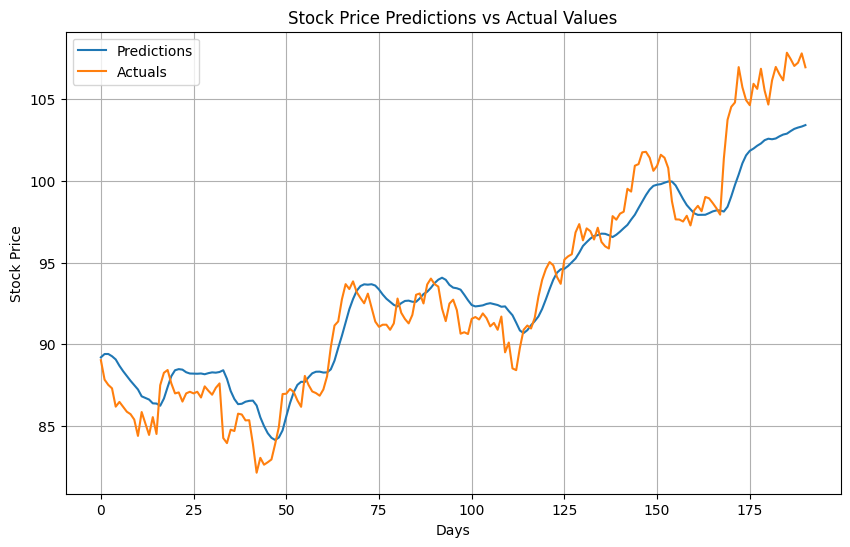

In [44]:
import matplotlib.pyplot as plt
# Assuming the time sequence is simply the index of each value
time_sequence = range(len(predictions_test))

# Plotting the data with updated specifications
plt.figure(figsize=(10, 6))
plt.plot(time_sequence, predictions_test, label='Predictions')  # Removed markers
plt.plot(time_sequence, actuals_test, label='Actuals')  # Removed markers
plt.title('Stock Price Predictions vs Actual Values')
plt.xlabel('Days')  # Updated xlabel to 'Days'
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# 2. RNN

In [34]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Forward propagate the RNN
        out, hn = self.rnn(x, h0.detach())
        
        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 200

# Create the RNN model instance
model = RNNModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# Loss and optimizer
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [35]:
model.train()
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time

print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.11498262733221054
Epoch  10 MSE:  0.006931956857442856
Epoch  20 MSE:  0.0042779818177223206
Epoch  30 MSE:  0.004165005404502153
Epoch  40 MSE:  0.0020829837303608656
Epoch  50 MSE:  0.0010908575495705009
Epoch  60 MSE:  0.0010841554030776024
Epoch  70 MSE:  0.001016484573483467
Epoch  80 MSE:  0.0009619878837838769
Epoch  90 MSE:  0.0009476035484112799
Epoch  100 MSE:  0.0009294924675486982
Epoch  110 MSE:  0.000918735284358263
Epoch  120 MSE:  0.0009087952203117311
Epoch  130 MSE:  0.0009004674502648413
Epoch  140 MSE:  0.0008933332283049822
Epoch  150 MSE:  0.0008869805606082082
Epoch  160 MSE:  0.0008813497261144221
Epoch  170 MSE:  0.0008763276855461299
Epoch  180 MSE:  0.000871823460329324
Epoch  190 MSE:  0.0008677711011841893
Training time: 24.557217597961426


In [36]:
# Set the model to evaluation mode
model.eval()

# Store predictions and actual values to calculate metrics later
predictions = []
actuals = []

# No gradient computation needed
with torch.no_grad():
    output_train = model(x_train)
    output_test = model(x_test)
    
predictions_train = scaler.inverse_transform(output_train).flatten() 
predictions_test = scaler.inverse_transform(output_test).flatten() 
actuals_train = scaler.inverse_transform(y_train).flatten()
actuals_test = scaler.inverse_transform(y_test).flatten()
actuals = np.append(actuals_train, actuals_test)

In [37]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error
mae = mean_absolute_error(actuals_test, predictions_test)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 4.212852588526874


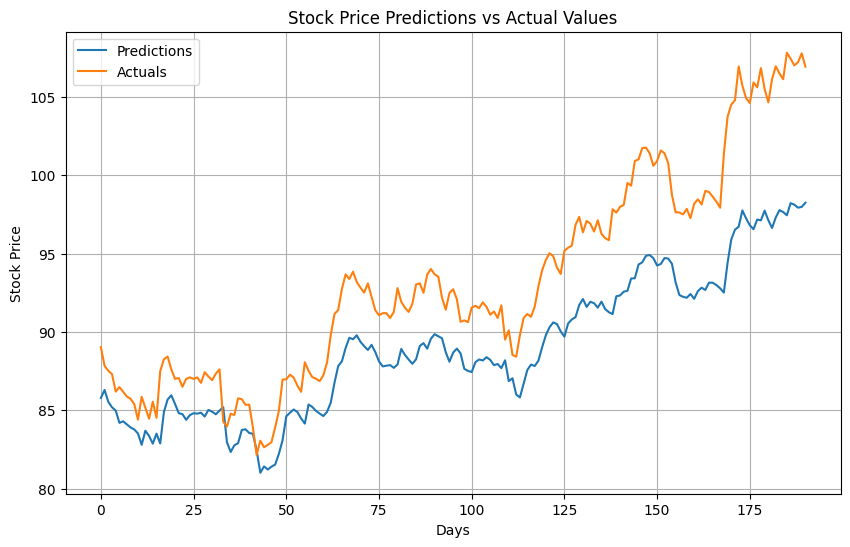

In [38]:
import matplotlib.pyplot as plt
# Assuming the time sequence is simply the index of each value
time_sequence = range(len(predictions_test))

# Plotting the data with updated specifications
plt.figure(figsize=(10, 6))
plt.plot(time_sequence, predictions_test, label='Predictions')  # Removed markers
plt.plot(time_sequence, actuals_test, label='Actuals')  # Removed markers
plt.title('Stock Price Predictions vs Actual Values')
plt.xlabel('Days')  # Updated xlabel to 'Days'
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. GRU

In [46]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [47]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [48]:
model.train()
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time

print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.11176668107509613
Epoch  10 MSE:  0.005391374230384827
Epoch  20 MSE:  0.005370038095861673
Epoch  30 MSE:  0.0015630725538358092
Epoch  40 MSE:  0.0013949447311460972
Epoch  50 MSE:  0.001085986034013331
Epoch  60 MSE:  0.0009914550464600325
Epoch  70 MSE:  0.0009371325140818954
Epoch  80 MSE:  0.0009091397514566779
Epoch  90 MSE:  0.0008861009264364839
Epoch  100 MSE:  0.0008724906947463751
Epoch  110 MSE:  0.0008608443895354867
Epoch  120 MSE:  0.000851525750476867
Epoch  130 MSE:  0.0008442063699476421
Epoch  140 MSE:  0.0008382779778912663
Epoch  150 MSE:  0.0008333437726832926
Epoch  160 MSE:  0.0008291852427646518
Epoch  170 MSE:  0.0008257313747890294
Epoch  180 MSE:  0.0008228419465012848
Epoch  190 MSE:  0.0008203311590477824
Training time: 92.98061895370483


In [49]:
# Set the model to evaluation mode
model.eval()

# Store predictions and actual values to calculate metrics later
predictions = []
actuals = []

# No gradient computation needed
with torch.no_grad():
    output_train = model(x_train)
    output_test = model(x_test)
    
predictions_train = scaler.inverse_transform(output_train).flatten() 
predictions_test = scaler.inverse_transform(output_test).flatten() 
actuals_train = scaler.inverse_transform(y_train).flatten()
actuals_test = scaler.inverse_transform(y_test).flatten()
actuals = np.append(actuals_train, actuals_test)

In [50]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error
mae = mean_absolute_error(actuals_test, predictions_test)

print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.077747354207871


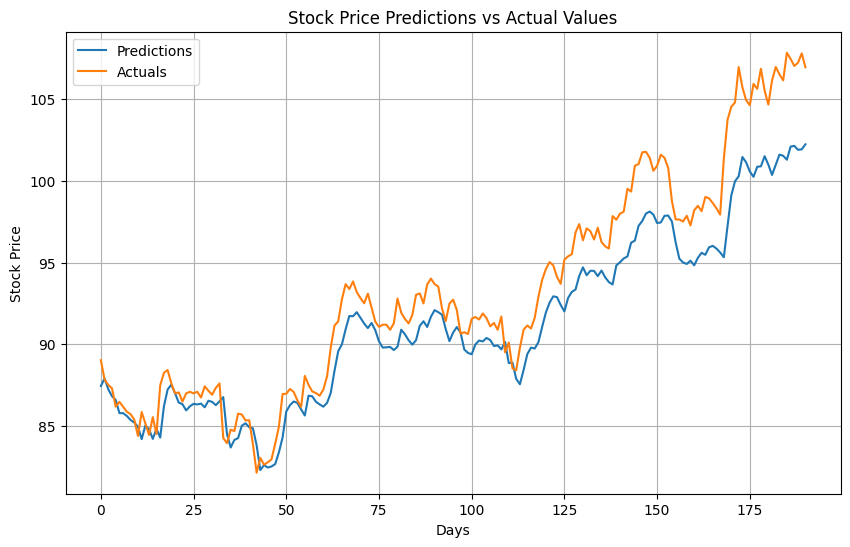

In [51]:
import matplotlib.pyplot as plt
# Assuming the time sequence is simply the index of each value
time_sequence = range(len(predictions_test))

# Plotting the data with updated specifications
plt.figure(figsize=(10, 6))
plt.plot(time_sequence, predictions_test, label='Predictions')  # Removed markers
plt.plot(time_sequence, actuals_test, label='Actuals')  # Removed markers
plt.title('Stock Price Predictions vs Actual Values')
plt.xlabel('Days')  # Updated xlabel to 'Days'
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()